In [1]:
import gdal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import raster_plot



In [2]:
#Import the data
raster_path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/"
raster = gdal.Open(raster_path + "/Cache_creek_clip.bil")#Get raster data

dem = raster.ReadAsArray()


creek= "Crack_canyon"
path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/"+creek+"/" #Set path to data
name = "Cache_creek_clip_fullProfileMC_forced_0.5_20_-4924088_20_90_3331.tree" #Set file name
#csv_name = "Cache_creek_clip_fullProfileMC_forced_0.5_20_-4924088_20_90_3331_for_Arc.csv"
csv_name = 'Cache_creek_clip_fullProfileMC_forced_0.5_20_192666952_20_90_3331_for_Arc.csv'

## IMPORT DATA for csv or tree files
#for csv files
creek_data = np.genfromtxt((path+csv_name), delimiter=',', skip_header=1, names=['id', 'x', 'y', 'chan_number', 'reciever_chan','node_on_reciever_chan', 'node', 'row','column', 'flow_distance', 'chi', 'elevation', 'drainage_area', 'n_data_points', 'm_mean','m_st_dev', 'm_std_err', 'b_mean', 'b_st_dev', 'b_std_err', 'DW_mean', 'DW_st_dev', 'DW_std_err', 'fitted_elev_mean', 'fitted_elev_stdev', 'fitted_elev_std_err'])
#for tree files
#creek_data = np.genfromtxt((path+name), delimiter=' ', skip_header=1, names=['chan_number', 'reciever_chan','node_on_reciever_chan', 'node', 'row','column', 'flow_distance', 'chi', 'elevation', 'drainage_area', 'n_data_points', 'm_mean','m_st_dev', 'm_std_err', 'b_mean', 'b_st_dev', 'b_std_err', 'DW_mean', 'DW_st_dev', 'DW_std_err', 'fitted_elev_mean', 'fitted_elev_stdev', 'fitted_elev_std_err'])


In [321]:
df =

In [43]:
fd_from_junction = creek_data['flow_distance']-min(creek_data['flow_distance'])




In [53]:
#This returns a mesh grid of x and y coordinates to plot up a full raster

def full_raster_xy_generator(raster):
    '''This function takes a raster from raster=gdal.Open('raster/path') and outputs a grid of
    x, y data to plot raster'''

    (upper_left_x, x_res, x_rotation, upper_left_y, y_rotation, y_res) = raster.GetGeoTransform()
    dx = x_res
    dy = y_res
    nx, ny = raster.RasterXSize, raster.RasterYSize  # Size of the original raster

    xllcenter = upper_left_x + dx/2  # x coordinate center of lower left pxl
    yllcenter = upper_left_y - dx/2 # y coordinate center of lower left pxl   

    #Create arrays of the x and y coordinates of each pixel (the axes)
    xcoordinates = [x*dx + xllcenter for x in range(nx)]
    ycoordinates = [y*dy + yllcenter for y in range(ny)]

    #Create 2 2d grids describing x and y coordinates
    X,Y = np.meshgrid(xcoordinates, ycoordinates) 


    return X, Y

X,Y = plot_coord(raster)

NameError: name 'plot_coord' is not defined

In [3]:
def raster_subsample_xy_generator(raster, creek_data):
    
    '''
    This function generates and x, y grid of a subsample of a full raster that
    only encompasses the stream of interest. This provides a quick way to analyze
    stream data without clipping rasters
    
    raster is the full raster from: raster = gdal.Open('raster/path').
    
    creek_data contains the x and y coordinates from the creek of interest, 
    should be stored as creek_data['x'] and creek_data['y'].

    x_res and y_res are the resoultions of the raster in x and y dimensions.

    nx_creek and ny_creek are the range of x and y that cover the creek.

    xoff and yoff are the number of pixels to start the plot of the raster.

    xsize and ysize are the range of pixels to plot the raster
    '''

    #Use gdal GetGeoTransorm to get important attributes of the raster
    (upper_left_x, x_res, x_rotation, upper_left_y, y_rotation, y_res) = raster.GetGeoTransform()

    #Define the range of the raster to plot that only covers the creek of interest
    nx_creek = max(creek_data['x']) - min(creek_data['x'])
    ny_creek = max(creek_data['y']) - min(creek_data['y'])
    xoff = ((min(creek_data['x'])-upper_left_x)/x_res).astype(int).item()
    yoff = ((upper_left_y - max(creek_data['y']))/x_res).astype(int).item()
    xsize = (nx_creek/x_res).astype(int).item()
    ysize = (ny_creek/x_res).astype(int).item()

    #Select a part of the raster from the full raster to plot
    array_part = raster.ReadAsArray(
        xoff=xoff,
        yoff=yoff,
        xsize=xsize,
        ysize=ysize)
    ##Can use this to test if the raster section is what you want.
    #plt.imshow(array_part)
    #plt.show()

    #Define the center of the upper left pixel of the creek area
    xcenter = min(creek_data['x']) + x_res/2  
    ycenter = max(creek_data['y']) - y_res/2 
    #Convert pixels into utm coordinates
    xcoordinates = [x*x_res + xcenter for x in range(xsize)]
    ycoordinates = [y*y_res + ycenter for y in range(ysize)]

    #Create a mesh grid of the coordinates for plotting the raster
    X,Y = np.meshgrid(xcoordinates, ycoordinates)
    
    return X, Y, array_part


In [6]:
X, Y, array_part = raster_subsample_xy_generator(raster, creek_data)


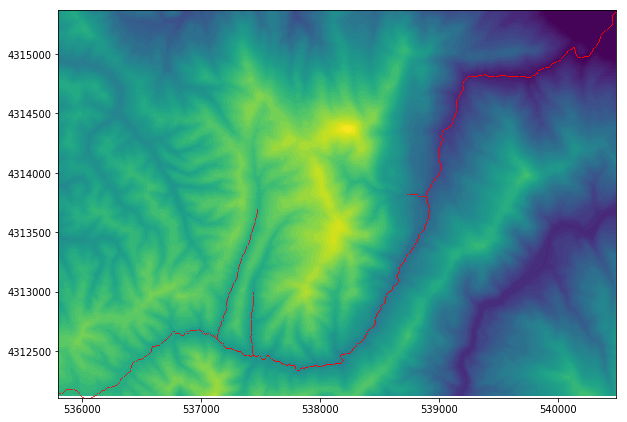

In [7]:
fig, ax = plt.subplots(1, figsize=(10,10), sharex=False) #define 2 subfigures

ax.contourf(X, Y, array_part, levels=np.linspace(np.amin(array_part[array_part > 0]),np.amax(array_part), 50))
ax.plot(creek_data['x'], creek_data['y'], 'ro',  markersize=1, markeredgewidth=0.0)
ax.set_aspect('equal')
plt.show()

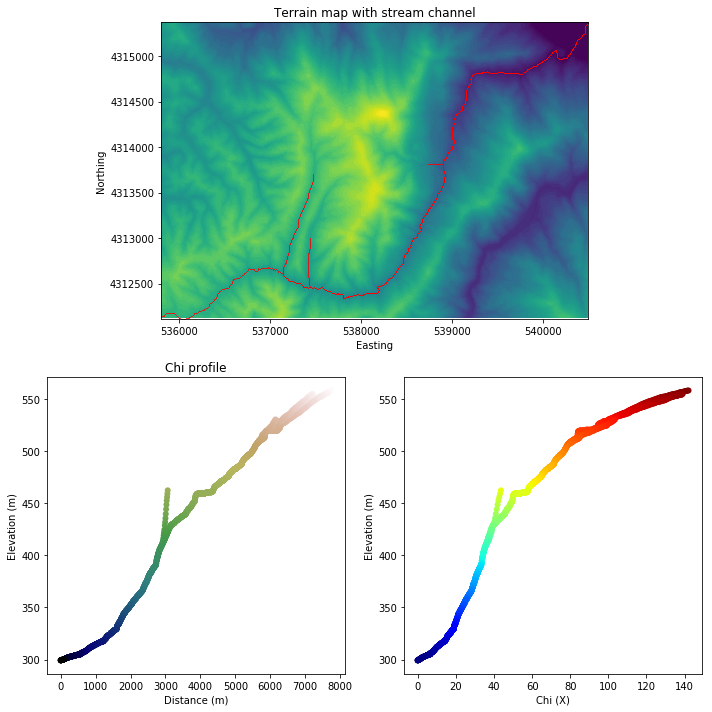

In [27]:
#calculate flow distance from junction
fd_from_junction = creek_data['flow_distance'] - min(creek_data['flow_distance'])


cm = plt.cm.gist_earth
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot(211)
ax2 = plt.subplot(223)#, xlim=[min(fd_from_junction)-100, max(fd_from_junction)+100], ylim=[min(creek_data['elevation'])-50, max(creek_data['elevation'])+50], aspect=10)#, sharey=ax3)#)
ax3 = plt.subplot(224)#,# xlim=[min(creek_data['chi'])-100, max(creek_data['chi'])+100], ylim=[min(creek_data['elevation'])-50, max(creek_data['elevation'])+50], aspect=10)#, sharey=ax3)#)  #,sharey=ax2)

ax1.contourf(X, Y, array_part, levels=np.linspace(np.amin(array_part[array_part > 0]),np.amax(array_part), 50))
ax1.plot(creek_data['x'], creek_data['y'], 'ro',  markersize=1, markeredgewidth=0.0)
ax1.set_aspect('equal')
ax1.set_title('Terrain map with stream channel')
ax1.set_ylabel('Northing')
ax1.set_xlabel('Easting')



ax2.scatter(fd_from_junction, creek_data['elevation'], c=creek_data['elevation'], cmap=cm, edgecolors='none')
#ax2.set_aspect(20)
ax2.set_title('Elevation profile')
ax2.set_ylabel('Elevation (m)')
ax2.set_xlabel('Distance (m)')


ax3.scatter(creek_data['chi'], creek_data['elevation'], c=creek_data['elevation'], cmap=plt.get_cmap("jet"), edgecolors='none')
#ax[2].text(3, 2500, 'm/n = 0.45')
#ax3.set_aspect(0.5)
ax2.set_title('Chi profile')
ax3.set_ylabel('Elevation (m)')
ax3.set_xlabel('Chi (X)')
#ax3.sharey=ax2

plt.tight_layout()

plt.show()

In [27]:
df = pd.DataFrame(creek_data)

source = ColumnDataSource(df)


In [38]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import bokeh.plotting as bp
from bokeh.models import ColumnDataSource, DataRange1d
from bokeh.models import HoverTool
#from bokeh.layouts import layout

# define boundaries of the plot area, default is adding on 1 km to easting and northing
def define_boundaries(df, r=1000):
    xmin = df['x'].min()
    xmax = df['x'].max()
    ymin =df['y'].min()
    ymax = df['y'].max()
    x_range = (xmin-r, xmax+r)
    y_range = (ymin-r, ymax+r)	
    return x_range, y_range


#define elevation boundaries for profile plots to use for interactive zooming
def define_elevation_boundaries(source_name, r=1000):
    zmin=min(source_name.data['elevation'])
    zmax=max(source_name.data['elevation'])
    elevation_range = DataRange1d(bounds=(zmin-r, zmax+r))
    return elevation_range


#using matplot lib colors in bokeh, change colors by variable in source dataset
def color_by_variable(cbv, source):
    colors = ["#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.jet(mpl.colors.Normalize()(source.data[cbv]))]
    source.data['colors'] = colors
    return colors



#Creating plots
#define tools to use
TOOLS = "pan,wheel_zoom,reset,save,lasso_select"

def stream_map(x_range, y_range, source, x='x', y='y', plot_width=600, plot_height=300, title='Title', x_axis_label='Label', y_axis_label='Label'):
    
    plot = bp.figure(plot_width=plot_width, plot_height=plot_height,x_range=x_range, y_range=y_range, title=title, x_axis_label=x_axis_label, y_axis_label=y_axis_label)
    cr = plot.circle(x='x', y='y', size=20,
                     fill_color="grey", hover_fill_color="firebrick",
                     fill_alpha=0.03, hover_alpha=0.3,
                     line_color=None, hover_line_color="white", source=source)
    plot.add_tools(HoverTool(tooltips=None, renderers=[cr], mode='mouse'))
    plot.circle(x='x', y='y', size=2, color='colors', source=source)
    return plot



def profile(elev_range, source, x='flow_distance', y='elevation', plot_width=500, plot_height=250, toolbar_location='above', title='Title', x_axis_label='Label', y_axis_label='Label'):
    
 
    plot = bp.figure(plot_width=500, plot_height=250, toolbar_location='above', 
                     title=title, x_axis_label=x_axis_label, y_axis_label=y_axis_label, y_range=elev_range)
    
    cr = plot.circle(x=x, y=y, size=20,
                     fill_color='grey', hover_fill_color="firebrick",
                     fill_alpha=0.03, hover_alpha=0.3,
                     line_color=None, hover_line_color="white", source=source)
    plot.add_tools(HoverTool(tooltips=None, renderers=[cr], mode='mouse'))
    plot.circle(x=x, y=y, size=2, color='colors', source=source) 
    return plot
    

In [39]:
x_range, y_range = define_boundaries(df)
elev_range = define_elevation_boundaries(source)

#cbv = 'x'
colors = color_by_variable('y', source=source)

In [40]:
sm = stream_map(x_range, y_range, source=source)
bp.show(sm)

ERROR:/Users/bmelosh/anaconda2/envs/geospatial/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: colors [renderer: GlyphRenderer(id='996fa8c3-f98e-4666-95fd-c8dd473bf8d9', ...)]
ERROR:/Users/bmelosh/anaconda2/envs/geospatial/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: colors [renderer: GlyphRenderer(id='d11f6434-ac7a-44b1-a98a-6163a2381490', ...)]
ERROR:/Users/bmelosh/anaconda2/envs/geospatial/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: colors [renderer: GlyphRenderer(id='5761acfa-a788-455f-a8f2-ef72c381ce3f', ...)]
ERROR:/Users/bmelosh/anaconda2/envs/geospatial/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: colors [renderer: GlyphRenderer(id='7e9d699e-0eec-4f35-bdac-4

In [4]:
df = pd.DataFrame(data)


In [4]:
## Plotting profiles with m_chi values as color scheme (Aug 18th, 2017)
import numpy as np
import matplotlib.pyplot as plt
from chi_profiles import *


## IMPORT DATA
creek= "Crack_canyon"
path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/"+creek+"/" #Set path to data
name = creek+"_MChiSegmented.csv" #Set file name

creek_data = np.genfromtxt((path+name), delimiter=',', skip_header=1, names=['node', 'row', 'col', 'latitude', 'longitude', 'chi', 'elevation', 'flow_distance', 'drainage_area', 'm_chi', 'b_chi', 'source_key', 'basin_key', 'segmented_elevation'])
creek_data_df = pd.DataFrame(creek_data)



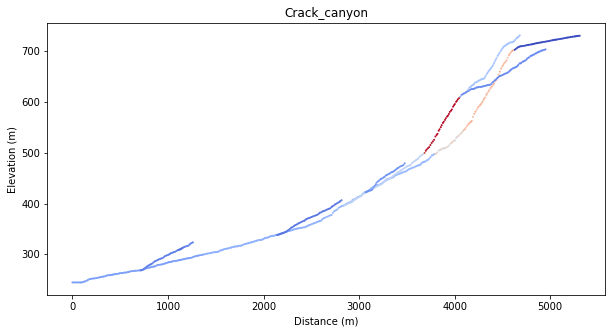

In [5]:
p = elevation_profile(creek_data_df, creek, 'm_chi')
plt.show(p)

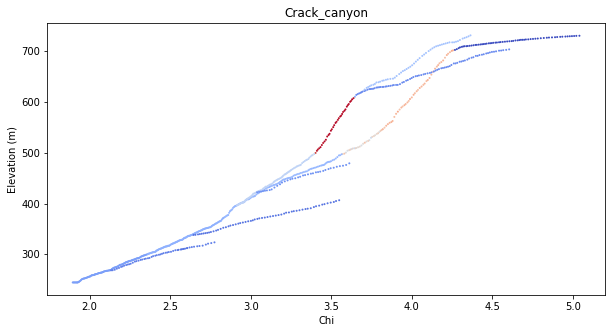

In [6]:
chi_profile(creek_data_df, creek, 'm_chi')

In [7]:
#convert the lat long to utm from creek data, chi segmented

import utm

def convert_lat_long(creek_data_df):
    x = []
    tup = []
    y = []

    for i in range(0,len(creek_data)):
        xi = utm.from_latlon(creek_data_df['latitude'][i], creek_data_df['longitude'][i])
        tup.append(xi)
        x_fin = tup[i][0]
        y_fin = tup[i][1]
        x.append(x_fin)
        y.append(y_fin)

    xd = pd.DataFrame(x, columns=['x'])
    yd = pd.DataFrame(y, columns=['y'])
    xdyd = pd.concat([xd, yd],axis=1)
    creek_data_df_new = pd.concat([creek_data_df,xdyd],axis=1)
    
    return creek_data_df_new

creek_data_df = convert_lat_long(creek_data_df)

In [8]:
X, Y, array_part= raster_subsample_xy_generator(raster, creek_data_df)

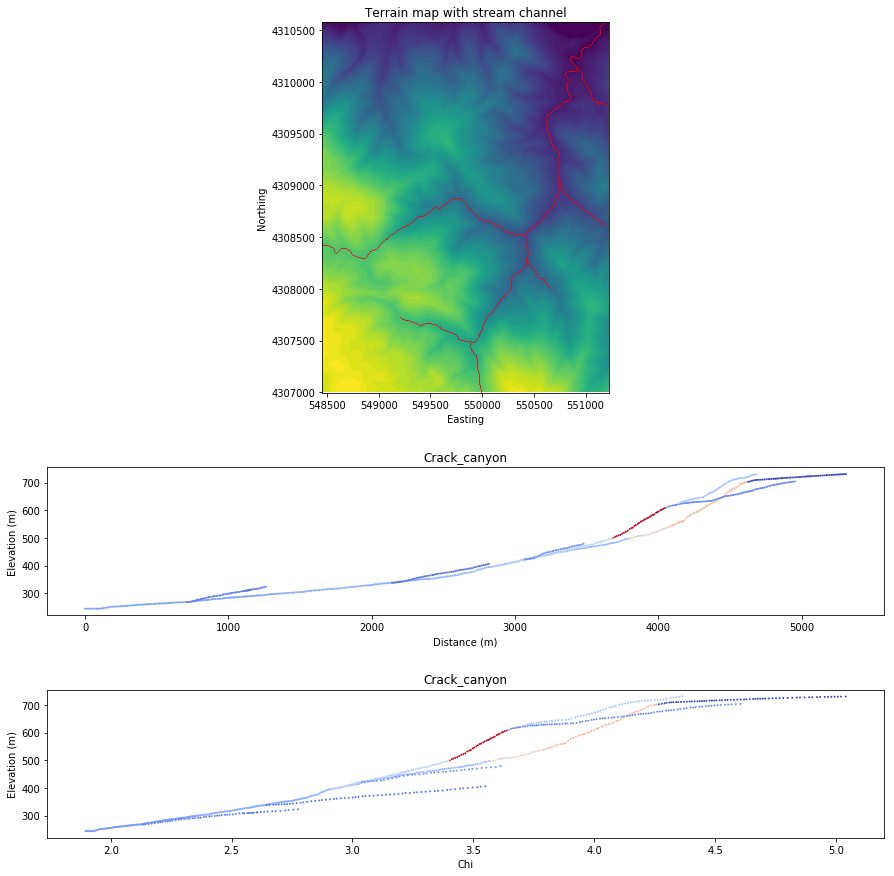

In [10]:
#calculate flow distance from junction (Working on getting distance into creek_data_df)
distance = creek_data_df['flow_distance'] - creek_data_df['flow_distance'].min()
#distance.columns = ['distance']

##creek_data_df = pd.concat([creek_data_df, distance],axis=1)


#Set up the figure and subplots
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.5)
ax1 = plt.subplot2grid((4, 1), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((4, 1), (2, 0))
ax3 = plt.subplot2grid((4, 1), (3, 0))

#cm = plt.cm.gist_earth #set colormap

ax1.contourf(X, Y, array_part, levels=np.linspace(np.amin(array_part[array_part > 0]),np.amax(array_part), 50))
ax1.plot(creek_data_df['x'], creek_data_df['y'], 'ro',  markersize=1, markeredgewidth=0.0)
ax1.set_aspect('equal')
ax1.set_title('Terrain map with stream channel')
ax1.set_ylabel('Northing')
ax1.set_xlabel('Easting')


ax2.scatter(distance, creek_data_df['elevation'], c=creek_data_df['m_chi'], cmap=plt.get_cmap("coolwarm"), s = 4, edgecolors='none')#, viridis, plasma
ax2.set_xlabel('Distance (m)')
ax2.set_ylabel('Elevation (m)')
ax2.set_title(creek)

ax3.scatter(creek_data_df['chi'], creek_data_df['elevation'], c=creek_data_df['m_chi'], cmap=plt.get_cmap("coolwarm"), s = 4, edgecolors='none')#, viridis, plasma
ax3.set_xlabel('Chi')
ax3.set_ylabel('Elevation (m)')
ax3.set_title(creek)


plt.show(fig)

In [97]:
creek_data_df['flow_distance'].min()

65244.0